# Class 10 - Responsible AI: Explainability

## Agenda
1. Transparency and Explainability
    - Model coefficients interpretation
    - Explainability

## Install Shap

In [ ]:
!pip install shap

## Imports

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,  roc_curve, auc

# Initialize shap
import shap
shap.initjs()

/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

**Dataset from:**

https://www.kaggle.com/datasets/rabieelkharoua/predict-liver-disease-1700-records-dataset

**Variables:**
- Age: Range: 20 to 80 years.
- Gender: Male (0) or Female (1).
- BMI (Body Mass Index): Range: 15 to 40.
- Alcohol Consumption: Range: 0 to 20 units per week.
- Smoking: No (0) or Yes (1).
- Genetic Risk: Low (0), Medium (1), High (2).
- Physical Activity: Range: 0 to 10 hours per week.
- Diabetes: No (0) or Yes (1).
- Hypertension: No (0) or Yes (1).
- Liver Function Test: Range: 20 to 100.
- Diagnosis: Binary indicator (0 or 1) of liver disease presence.

In [3]:
data_url = 'https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/MLCatolica24/main/Aula%2010%20-%20%20Responsible%20AI/data_class10/Liver_disease.csv'
df = pd.read_csv(data_url)
df.shape

(1700, 11)

In [4]:
# see first rows
df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,0,35.857584,17.272828,0,1,0.658940,0,0,42.734240,1
1,71,1,30.732470,2.201266,0,1,1.670557,1,0,67.309822,1
2,48,0,19.971407,18.500944,0,0,9.928308,0,0,63.738956,0
3,34,1,16.615417,12.632870,0,0,5.630129,0,0,64.555873,1
4,62,1,16.065830,1.087815,0,1,3.566218,1,0,77.868689,1


## EDA

In [5]:
# Obtain statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1700.0,50.394118,17.641915,20.000000,35.000000,51.000000,66.000000,80.000000
Gender,1700.0,0.504118,0.500130,0.000000,0.000000,1.000000,1.000000,1.000000
BMI,1700.0,27.699801,7.210400,15.004710,21.455414,27.925367,33.957668,39.992845
AlcoholConsumption,1700.0,9.832309,5.757472,0.003731,4.841811,9.828195,14.871671,19.952456
Smoking,1700.0,0.291765,0.454708,0.000000,0.000000,0.000000,1.000000,1.000000
GeneticRisk,1700.0,0.521765,0.666262,0.000000,0.000000,0.000000,1.000000,2.000000
PhysicalActivity,1700.0,5.000993,2.847074,0.001852,2.622121,5.022883,7.401642,9.994964
Diabetes,1700.0,0.142353,0.349515,0.000000,0.000000,0.000000,0.000000,1.000000
Hypertension,1700.0,0.154706,0.361730,0.000000,0.000000,0.000000,0.000000,1.000000
LiverFunctionTest,1700.0,59.863867,22.996262,20.019254,40.024216,59.513146,79.428755,99.991413


In [6]:
# Check the distributions of the classes
df['Diagnosis'].value_counts()

Diagnosis
1    936
0    764
Name: count, dtype: int64

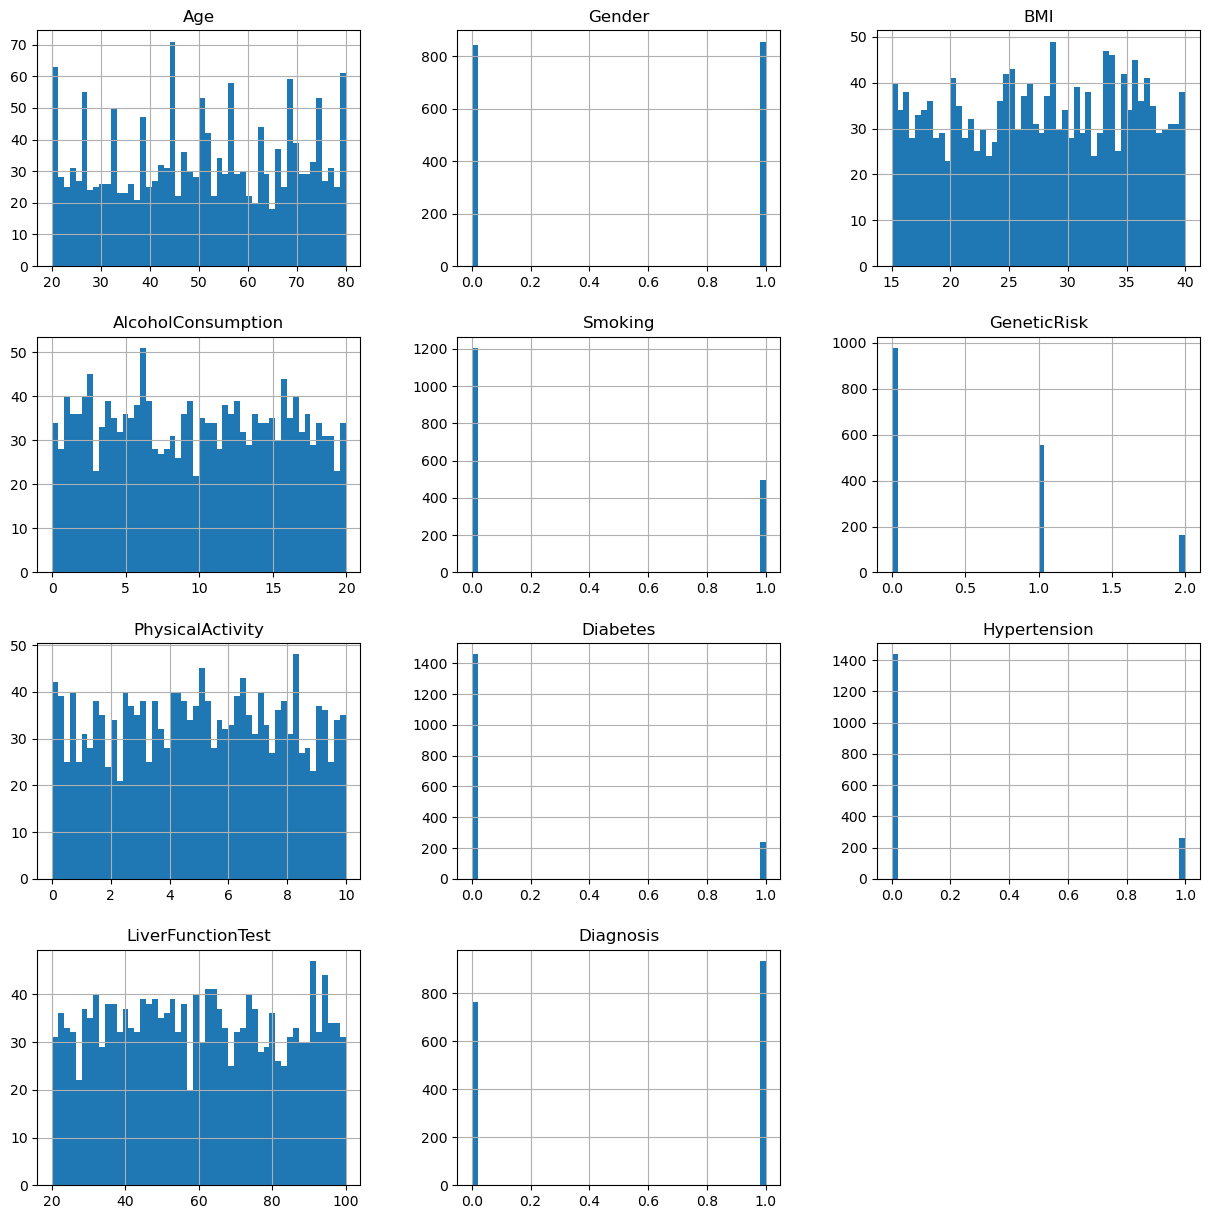

In [7]:
# Plot the histograms
hists = df.hist(bins=50, figsize=(15,15))
plt.show()

## Data Selection and Train/Test split

In [8]:
# DEfine the target column
target_col = 'Diagnosis'

In [9]:
# Select the features to the X and y variables
X = df.drop(columns=[target_col])
y = df[target_col]

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [11]:
# Select continuous and categorical columns
continuous_cols = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest']
categorical_cols = ['Gender', 'Smoking', 'GeneticRisk', 'Diabetes', 'Hypertension']

In [12]:
# Create copy of the X_train and X_test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [13]:
# Scale the continuous variables
scaler = StandardScaler()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [14]:
X_train_scaled.head(3)

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest
169,-0.974097,1,-1.671551,-0.827988,1,0,0.679718,0,0,0.496165
1618,1.109675,0,0.495120,0.465713,0,0,-1.701082,0,0,-0.348872
205,1.560220,0,0.435707,-0.918351,0,0,0.815823,0,0,0.046895


## 1. Transparency and Explainability

### 1.1. Logistic Regression

Model Training

In [15]:
# Train a Logistic Regression with class_weight 'balanced'
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Model Evaluation

In [16]:
# Predict the classes for X_test
y_predict = clf.predict(X_test_scaled)

In [17]:
# Check the accuracies
accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.81


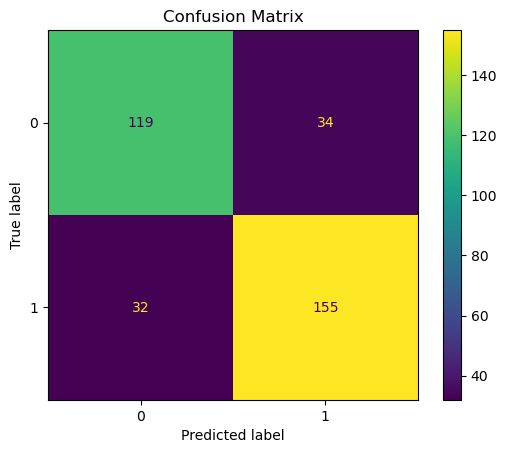

In [18]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Model coefficients interpretation

Odds Ratio (Recap from class 6)

In [19]:
# Extract coefficients and feature names
coefficients = clf.coef_[0]
feature_names = X.columns

In [20]:
coefficients

array([ 0.57576984,  1.34199026,  0.53471414,  1.37136818,  1.83588235,
        0.77702838, -0.29886224,  0.99766457,  1.63638681,  1.38302164])

In [21]:
feature_names

Index(['Age', 'Gender', 'BMI', 'AlcoholConsumption', 'Smoking', 'GeneticRisk',
       'PhysicalActivity', 'Diabetes', 'Hypertension', 'LiverFunctionTest'],
      dtype='object')

In [22]:
# Compute the exponential function
odds_ratio = np.exp(coefficients)

In [23]:
# Sort coefficients and feature names by absolute odds_ration
sorted_indices = np.argsort(np.abs(odds_ratio))[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_odds = odds_ratio[sorted_indices]

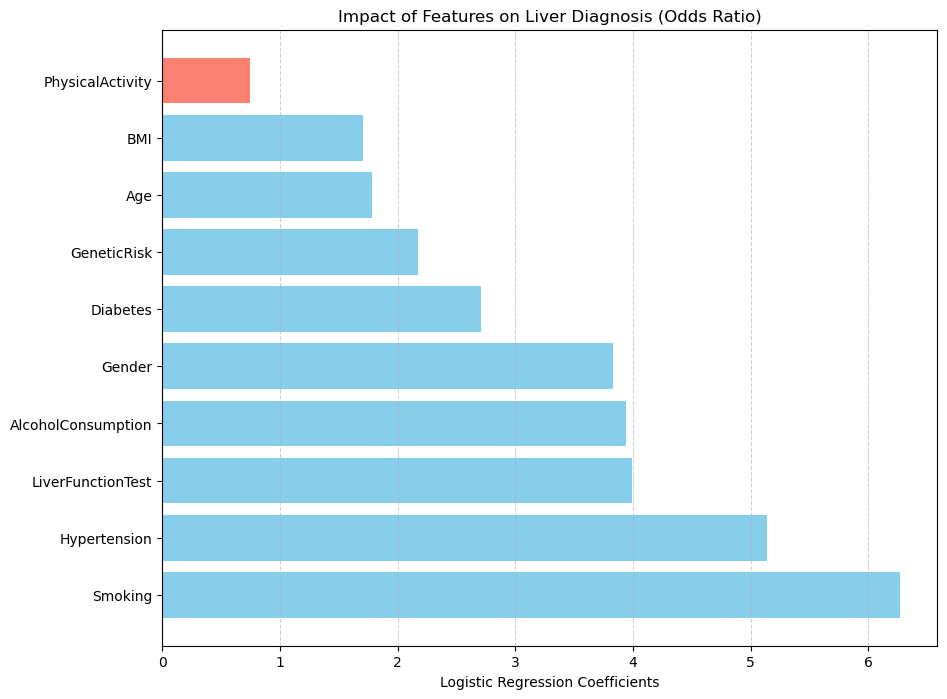

In [24]:
# Plot the odds ratio
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_odds, color=['skyblue' if coef > 1 else 'salmon' for coef in sorted_odds])
plt.xlabel('Logistic Regression Coefficients')
plt.title('Impact of Features on Liver Diagnosis (Odds Ratio)')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

SHAP values 
- They take into consideration not only the model weights but also the values

In [25]:
# Initialize the SHAP explainer
explainer_LR = shap.LinearExplainer(clf, X_train_scaled)

In [26]:
# COmpute the shap values for the X_test dataset
shap_values_LR = explainer_LR.shap_values(X_test_scaled)

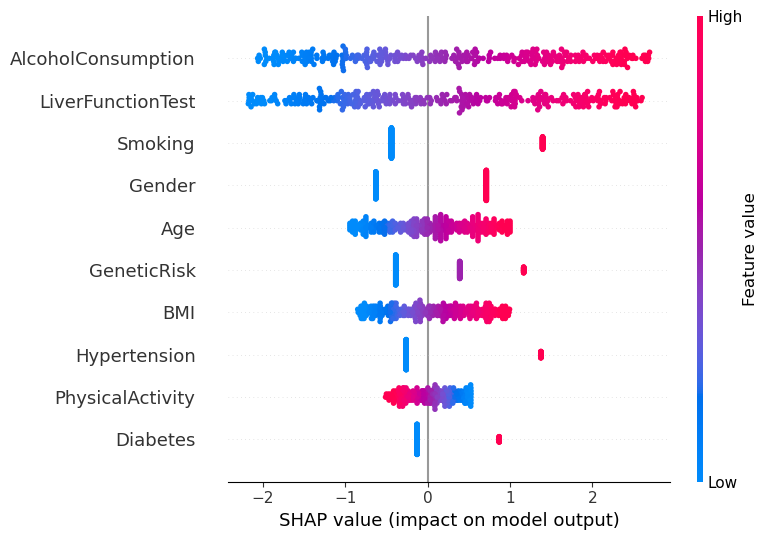

In [27]:
# Plot summary_plot of shap
shap.summary_plot(shap_values_LR, X_test_scaled, feature_names=X.columns)

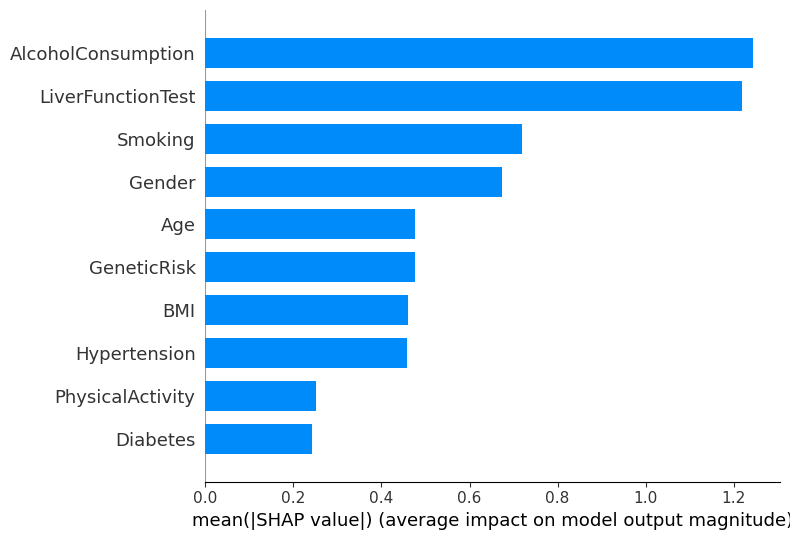

In [28]:
# Plot summary_plot with bars
shap.summary_plot(shap_values_LR, X_test_scaled, feature_names=X.columns, plot_type='bar')

### 1.2. Decision Tree

Model Training

In [29]:
# Train the decision tree model
dt_model = DecisionTreeClassifier(max_depth=5 ,class_weight='balanced',random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Model Evaluation

In [30]:
# Make predictions on train set
y_pred_dt = dt_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_dt)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.88


In [31]:
# Make predictions on test set
y_pred_dt = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.75


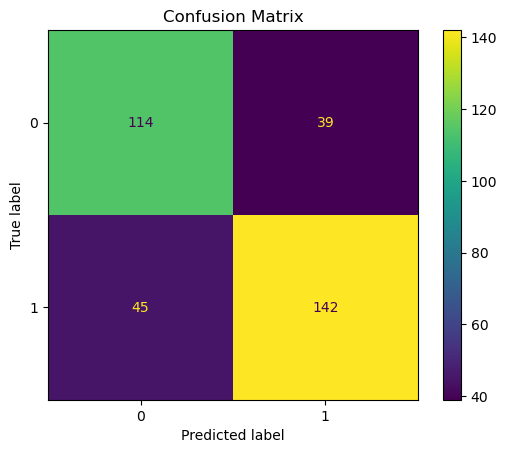

In [32]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

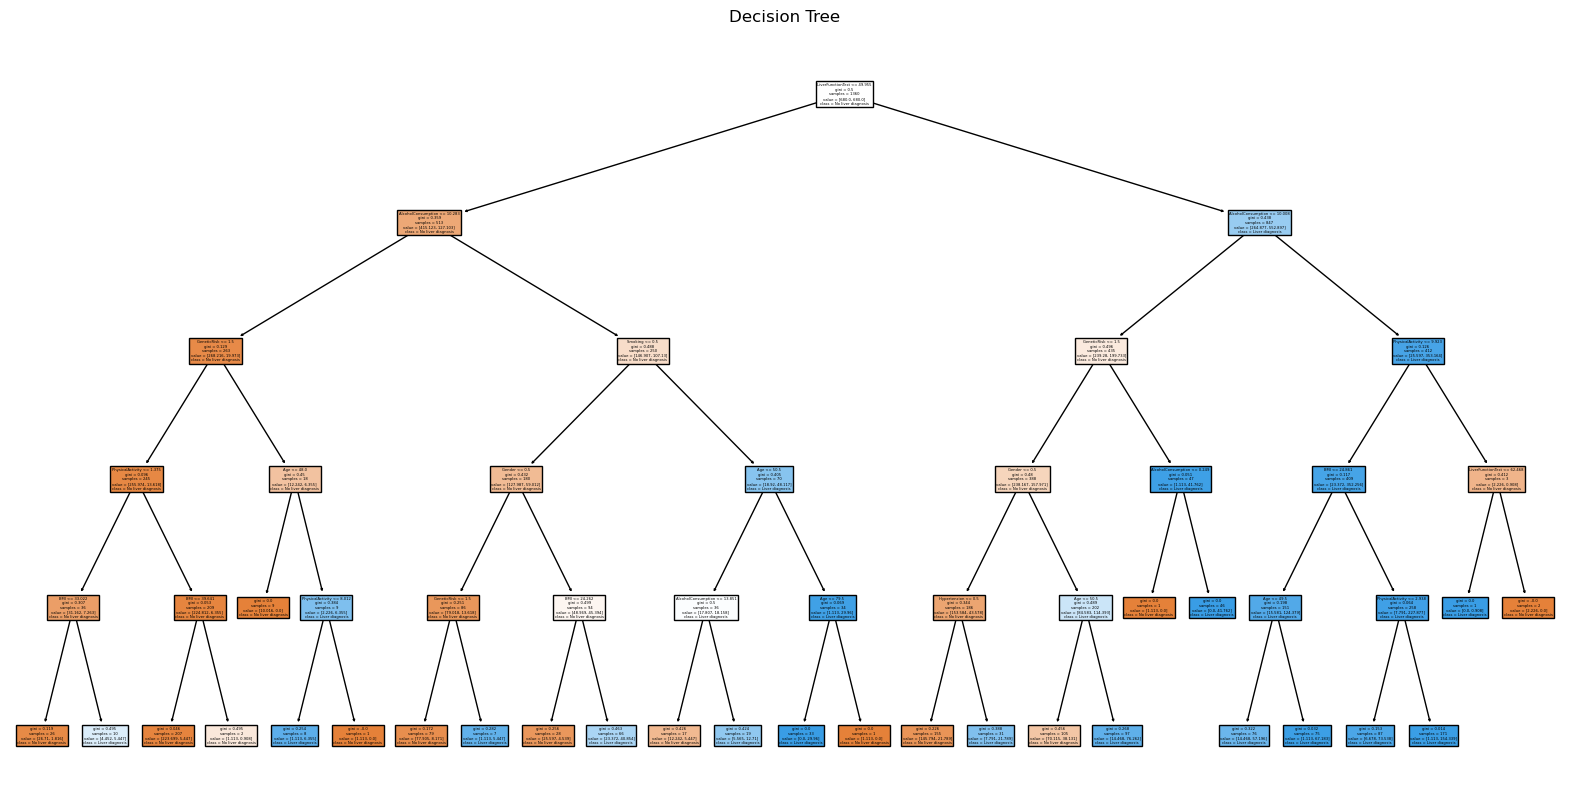

In [33]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['No liver diagnosis', 'Liver diagnosis'], filled=True)
plt.title('Decision Tree')
plt.show()

Feature Importance (Recap from class 7)

In [34]:
# Retrieve feature importances
feature_importances = dt_model.feature_importances_

In [35]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

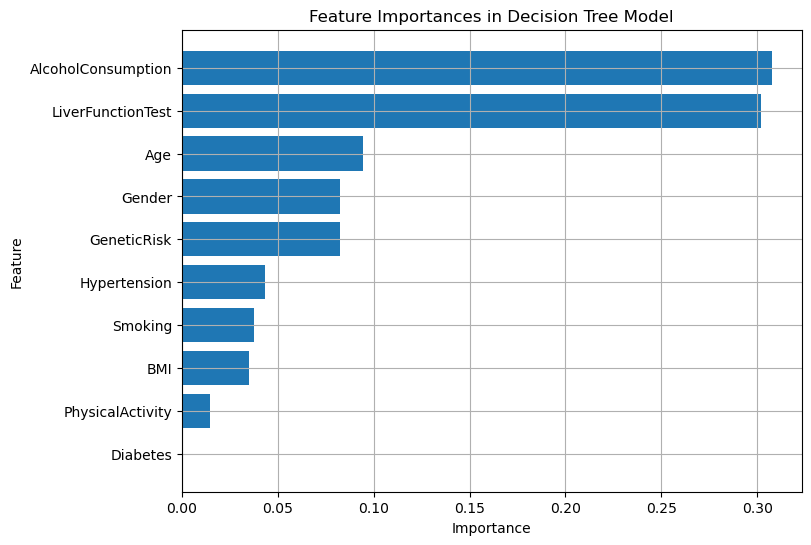

In [36]:
# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(True)
plt.show()

SHAP values

In [37]:
# Initialize SHAP for Tree based models
explainer_dt  = shap.TreeExplainer(dt_model)

In [38]:
# Compute SHAP values for X_test given the Decision Tree model trained
shap_values_dt = explainer_dt(X_test).values[:, :, 1]

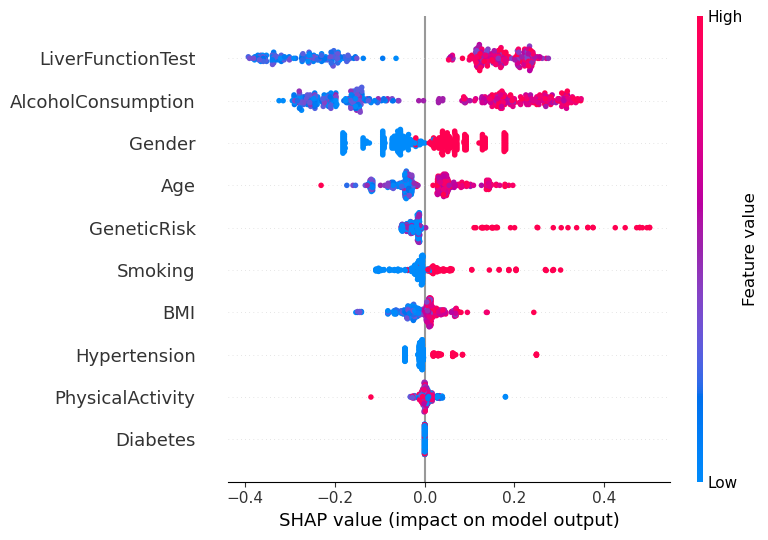

In [39]:
# Plot summary plot
shap.summary_plot(shap_values_dt, X_test)

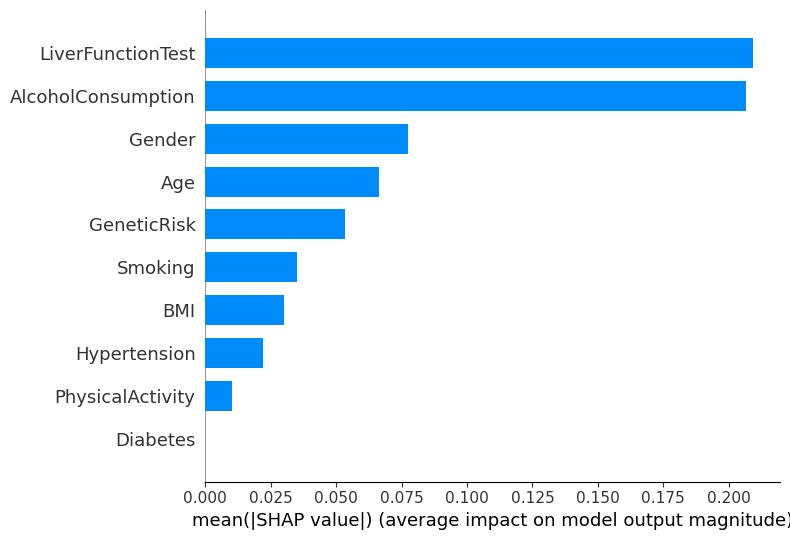

In [40]:
# Plot bar summary_plot
shap.summary_plot(shap_values_dt, X_test, plot_type="bar")

### Random Forest

Model Traning

In [41]:
# Train the Random Forest model --> we are choosing a random attributes just to prevent overfitting
RF_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10, min_samples_split=10,class_weight='balanced',random_state=42)
RF_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=42)

Model Evaluation

In [42]:
# Make predictions on train set
y_pred_RF = RF_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_RF)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.92


In [43]:
# Make predictions on test set
y_pred_RF = RF_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_RF)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.85


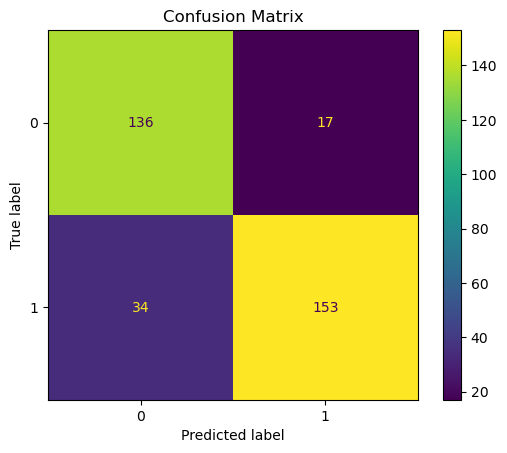

In [44]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=RF_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Feature Importance

- Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree

In [45]:
# Retrieve feature importances
feature_importances = RF_model.feature_importances_

In [46]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

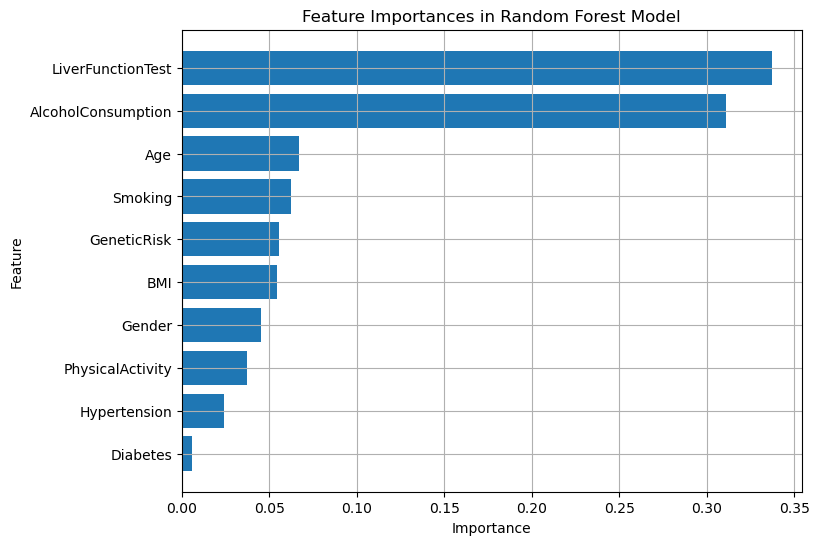

In [47]:
# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(True)
plt.show()

SHAP values

In [48]:
# Initialize SHAP for Tree based models
explainer_rf  = shap.TreeExplainer(RF_model)

In [49]:
# Compute SHAP values for X_test given the Decision Tree model trained
shap_values_rf = explainer_rf(X_test).values[:, :, 1]

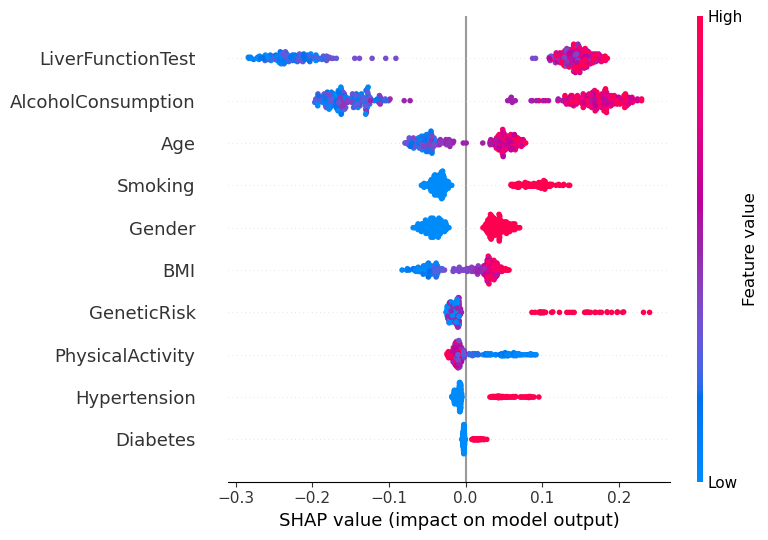

In [50]:
# Plot summary_plot
shap.summary_plot(shap_values_rf, X_test)

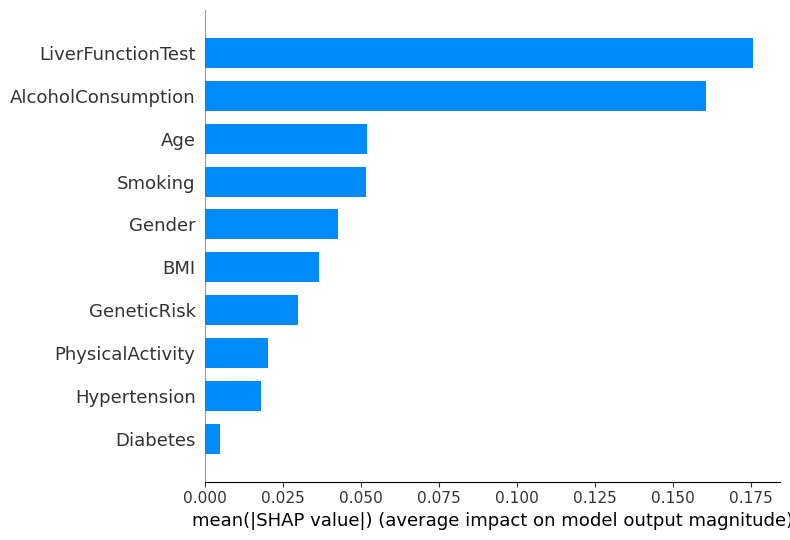

In [51]:
# Plot bar summary_plot
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")